In [1]:
from pathlib import Path
from cc_model.load_datasets import load_gt_dataset_cached


import graph_tool.all as gt
from cc_model.wl import WL, labelings_are_equivalent
from cc_model.fast_graph import FastGraph
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
# Code that should make matplotlib use ACM font (libertine)
import matplotlib

rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [3]:
datasets = ["karate", 
            "phonecalls",
            "HepPh", 
            "AstroPh", 
#            "web-Google",
#             "soc-Pokec"
#            "deezer_HR", "deezer_HU", "deezer_RO","tw_musae_DE",
#            "tw_musae_ENGB","tw_musae_FR","lastfm_asia","fb_ath",
#            "fb_pol", "facebook_sc"
           ]

In [4]:
dataset_path = Path("/home/felix/projects/colorful_configuration/datasets")

In [19]:
epsilon=1e-15
max_iter = 600

In [20]:
def rewire_run_pagerank_for_round(G, depth, in_base_pagerank, number_of_rewires=10, verbosity=0):
    """ Calculate similarities in pagerank vectors for rewired G
    G :      FastGraph
    depth:    depth of WL iteration to be used
    in_base_pagerank :    in pagerank of G
    Generate synthethic networks which have the same WL colors as G
      at specific depth and return absolute error sum
    """
    pagerank_args = {"mode":"in",
                     "epsilon":epsilon,
                     "max_iter":max_iter,
                     "return_err":True}
    
    errors = []
    for i in range(number_of_rewires):
        G.rewire(depth)
        
        in_pagerank, err = G.calc_ev(**pagerank_args)
        if err<0:
            print("iteration did not converge, err was", err)
            #eigenvalue = get_eigenvalue(G)
        if verbosity > 0:
            print("the error in pagerank is:\r\n", err)
        pagerank_diff = np.sum(np.abs(in_base_pagerank-in_pagerank))
        errors.append(pagerank_diff)

    return errors

In [21]:
def compute_ev_on_all_datasets(n_rewires, verbosity=0):
    """ computes pagerank and compares it with rewired graphs
    """
    list_values = []
    list_stds = []
    for dataset in datasets:
        if dataset is None:
            list_means.append([])
            list_stds.append([])
            continue
        if verbosity > 0:
            print(dataset)
        G_base = load_gt_dataset_cached(dataset_path,
                                        dataset,
                                        verbosity=verbosity,
                                        force_reload=False)
        edges = np.array(G_base.get_edges(), dtype=np.uint32)
        
        G = FastGraph(edges, G_base.is_directed())
        #print(G.__dict__)
        #print(G.out_degree)
        #print(WL(G.to_gt()))
        values = get_MAE_for_iterations(G,
                                             n_rewires=n_rewires,)
        

        #print(WL_fast(to_symmetric_edges(G._edges)))
        #print(G.base_partitions)
        list_values.append(values)
    return list_values

In [22]:
def to_symmetric_edges(edges):
    n_edges = edges.shape[0]
    out = np.empty((2 * n_edges,2), dtype=edges.dtype)
    out[:n_edges,:]=edges
    out[n_edges:,1]=edges[:,0]
    out[n_edges:,0]=edges[:,1]
    return out

In [23]:
def get_MAE_for_iterations(G, n_rewires):
    values = []
    G.ensure_edges_prepared(initial_colors=None)
    #print(G.dead_arr.sum(axis=1)/G._edges.shape[0])
    in_base_ev, err = G.calc_ev("base in",
                              epsilon=epsilon,
                              max_iter=max_iter,
                              return_err=True)
    #G_gt = G.to_gt(switch=False)
    #value, vector = gt.eigenvector(G_gt, epsilon = 1e-12)
    #vector = np.array(vector.get_array())
    #vector = vector/sum(vector)
    #print(in_base_ev, err)
    #print((in_base_ev - vector).max())
    print("total WL iterations ", G.wl_iterations)
    #print(G.base_partitions.shape)
    #print(G.edges.shape)
    for WL_round in range(G.wl_iterations-1,-1,-1):
        if verbosity>0:
            print("WL round", WL_round)

        MAEs = rewire_run_pagerank_for_round(G,
                                             WL_round,
                                             in_base_ev,
                                             number_of_rewires=n_rewires,
                                             verbosity=0)
        #print(MAEs)
        values.append(MAEs)
    return values

In [24]:
from cc_model.fast_wl import WL_fast


In [25]:
verbosity=1
number_of_samples = 100
list_values = compute_ev_on_all_datasets(number_of_samples, verbosity=1)

karate
resetting
total WL iterations  3
WL round 2
WL round 1
WL round 0
phonecalls
resetting
total WL iterations  9
WL round 8
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
iteration did not converge, err was -4.6904945889705943e-07
iteration did not converge, err was -3.3637031207874725e-15
iteration did not converge, err was -7.097180551556581e-15
iteration did not converge, err was -1.6701993364453963e-13
iteration did not converge, err was -5.808449701719771e-13
iteration did not converge, err was -3.644413114935429e-13
HepPh
resetting
total WL iterations  8
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
iteration did not converge, err was -1.701356402033831e-14
iteration did not converge, err was -9.538568145459361e-15
iteration did not converge, err was -1.3076166469546865e-13
iteration did not converge, err was -1.268688132741991e-14
WL round 1
WL round 0
AstroPh
resetting
total WL iterations  5
WL round 4
WL round 3


In [27]:
print(11/11.1)
print(101/101.1)
print(10/10.1)

0.990990990990991
0.9990108803165183
0.9900990099009901


In [ ]:
now = datetime.now()
if number_of_samples > 10:
    save_prefix = now.strftime("%Y_%m_%d__%H_%M_%S")
    print(save_prefix)
    with open("./results/"+"_eigenvector_"+save_prefix+".pkl", "wb") as f:
        pickle.dump((list_values, datasets), f)

In [29]:
def get_mean_std(list_values):
    list_means = []
    list_stds0 = []
    list_stds1 = []

    for values in list_values:
        mean = np.mean(values)+1e-20
        quantiles = np.quantile(values, [0.5-0.68/2, 0.5+0.68/2,])
        list_means.append(mean)
        list_stds0.append(quantiles[0])
        list_stds1.append(quantiles[1])
    list_stds = [list_stds0[::-1], list_stds1[::-1]]
    return list_means[::-1], list_stds

def quickplot(list_values, datasets, show_alpha=False, save_date=None, xlim=None):
    plt.figure(figsize=(10,6))
    if show_alpha:
        x=np.linspace(0,15)
        y=2 *alpha**(x+1)
        plt.plot(x,y)
    
    markers = [".", "o", "<", "s", "*"]
    markers2 = ["^", "o", "+", "x", "_"]
    marker_sizes = 6*np.array([1.4, 1, 1.5, 1, 1.9,])
    


    for values, label, marker, ms in zip(list_values, datasets, markers2, marker_sizes):
        means, stds = get_mean_std(values)
        plt.errorbar(x=np.arange(len(means)),y=means, yerr=stds, label=label, fmt=marker+"--", markersize=ms)


    plt.ylabel("SAE of eigenvector centrality")
    plt.xlabel("depth $d$")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.yscale("log")
    plt.legend()
    #
    if save_date is None:
        plt.title("Convergence of eigenvector for synthetic networks ")
    else:
        time_str = save_date.strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig(Path(".")/Path('images')/f'eigenvector_{time_str}.pdf', bbox_inches = 'tight')
    

In [30]:
quickplot(list_values, datasets, show_alpha=False, save_date=datetime.now())

NameError: name 'list_values' is not defined

In [36]:
load_dataset=True
if load_dataset:
    load_date = datetime(2022,1,7, 19,11,2)
    save_prefix = load_date.strftime("%Y_%m_%d__%H_%M_%S")
    with open("./results/"+"_eigenvector_"+save_prefix+".pkl", "rb") as f:
        (list_values2, datasets2) = pickle.load(f)
        if datasets2[0]=="karate":
            datasets2=datasets2[1:]
            list_values2=list_values2[1:]

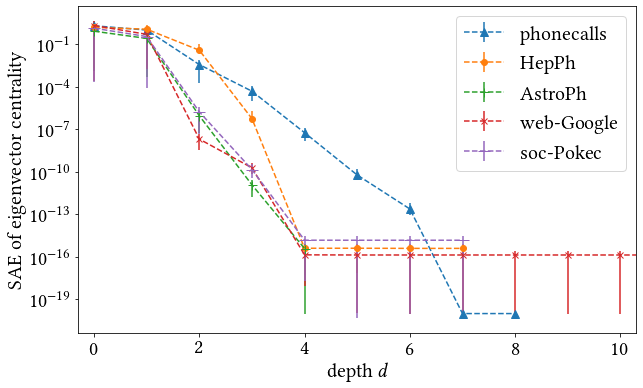

In [39]:
quickplot(list_values2, datasets2, save_date=load_date, xlim=(-0.3,10.3))